# Spam Detection using Machine Learning

This notebook demonstrates a step-by-step approach to classify messages as spam or not spam using NLP techniques.  


---

## 1. Importing Libraries


In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from collections import Counter
from wordcloud import WordCloud

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 2. Loading and Cleaning the Dataset
- Load the dataset.
- Drop unnecessary columns.
- Encode the target labels (Spam: 1, Not Spam: 0).
- Remove duplicate entries.


In [2]:
# Load dataset
df = pd.read_csv(r'D:\Projects\NLP_Projects\Spam Classification using logistic regression\spam.csv', encoding='latin1')


# Drop unnecessary columns
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

# Rename columns
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

# Encode target labels
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

# Remove duplicate rows
df = df.drop_duplicates()

# Display dataset info
df.info()

# Sample data
df.sample(5)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 5169 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   target  5169 non-null   int64 
 1   text    5169 non-null   object
dtypes: int64(1), object(1)
memory usage: 121.1+ KB


,target,text
3492,0,"Cool, text me when you head out"
3657,0,R u here yet? I'm wearing blue shirt n black p...
4540,0,Hiya. How was last night? I've been naughty an...
2379,0,"Good evening Sir, hope you are having a nice d..."
1927,0,Omg it could snow here tonite!


## 3. Exploratory Data Analysis (EDA)
- Visualize the distribution of spam and not spam messages.
- Generate text statistics such as the number of characters, words, and sentences.
- Explore correlations between these features.


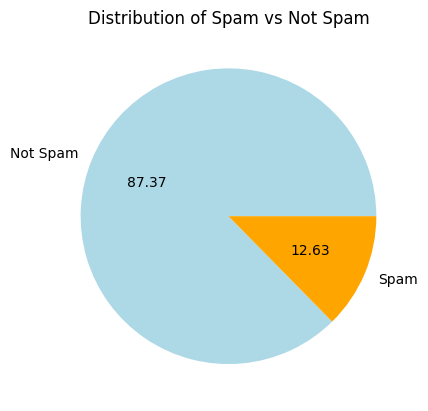

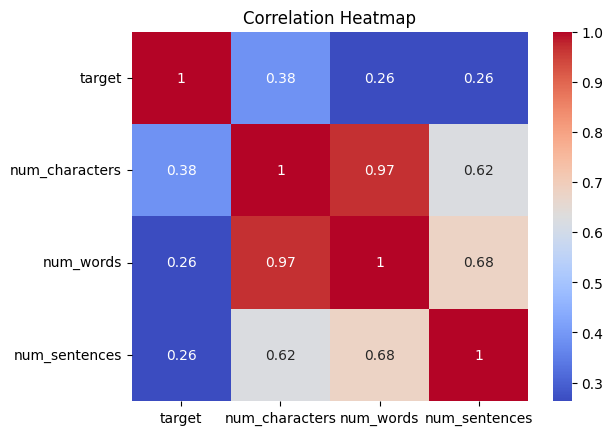

In [3]:
# Distribution of spam vs not spam
plt.pie(df['target'].value_counts(), labels=['Not Spam', 'Spam'], autopct="%0.2f", colors=['lightblue', 'orange'])
plt.title("Distribution of Spam vs Not Spam")
plt.show()

# Add text statistics
df['num_characters'] = df['text'].apply(len)
df['num_words'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x: len(nltk.sent_tokenize(x)))

# Correlation heatmap
sns.heatmap(df[['target', 'num_characters', 'num_words', 'num_sentences']].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()


## 4. Text Preprocessing
- Convert text to lowercase.
- Tokenize the text.
- Remove special characters, stop words, and punctuations.
- Apply stemming.


In [4]:
# Initialize the stemmer
ps = PorterStemmer()


# Define text preprocessing function
def transform_text(text):
    text = text.lower()  # Convert to lowercase
    text = nltk.word_tokenize(text)  # Tokenize text
    text = [word for word in text if word.isalnum()]  # Remove non-alphanumeric characters
    text = [word for word in text if word not in stopwords.words('english') and word not in string.punctuation]  # Remove stopwords and punctuations
    text = [ps.stem(word) for word in text]  # Apply stemming
    return " ".join(text)

# Apply text preprocessing
df['transformed_text'] = df['text'].apply(transform_text)

# Display transformed text
df.sample(5)


,target,text,num_characters,num_words,num_sentences,transformed_text
4635,0,K k pa Had your lunch aha.,26,8,1,k k pa lunch aha
5421,0,"Hi elaine, is today's meeting confirmed?",40,9,1,hi elain today meet confirm
3225,0,"Rose for red,red for blood,blood for heart,hea...",281,75,7,rose red red blood blood heart heart u send ti...
40,0,Pls go ahead with watts. I just wanted to be s...,82,20,4,pl go ahead watt want sure great weekend abiola
5432,0,Thanx a lot 4 ur help!,22,7,1,thanx lot 4 ur help


## 5. Visualizing Frequent Words
Generate WordClouds for spam and not spam messages.


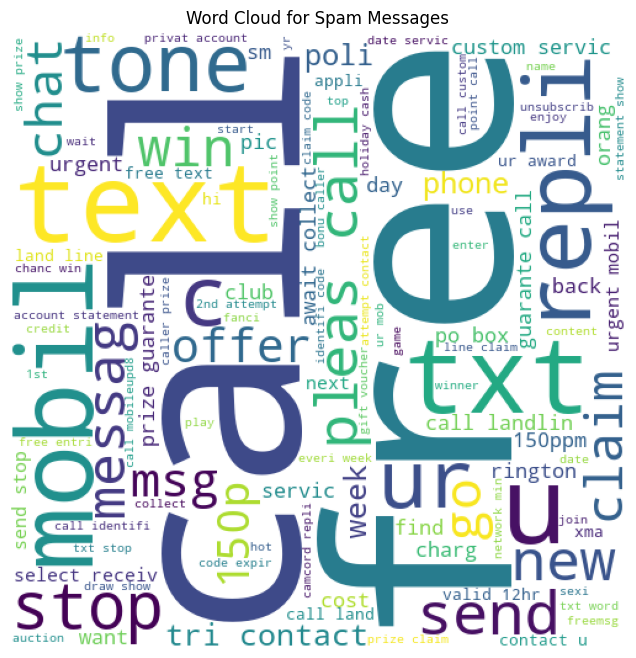

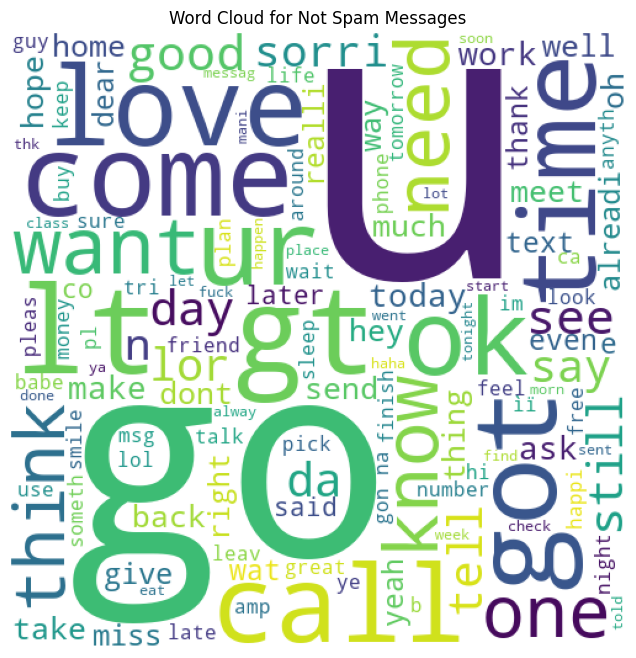

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate WordCloud for spam messages
spam_wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white').generate(
    df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(8, 8))
plt.imshow(spam_wc)
plt.axis("off")
plt.title("Word Cloud for Spam Messages")
plt.show()

# Generate WordCloud for not spam messages
not_spam_wc = WordCloud(width=500, height=500, min_font_size=10, background_color='white').generate(
    df[df['target'] == 0]['transformed_text'].str.cat(sep=" "))
plt.figure(figsize=(8, 8))
plt.imshow(not_spam_wc)
plt.axis("off")
plt.title("Word Cloud for Not Spam Messages")
plt.show()


## 6. Model Training and Evaluation
- Convert text into numerical format using TF-IDF.
- Train Logistic Regression and Naive Bayes models.
- Evaluate model performance.


In [6]:
# Convert text into numerical representation
tfidf_vectorizer = TfidfVectorizer(max_features=3000)
X = tfidf_vectorizer.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Bernoulli Naive Bayes": BernoulliNB()
}

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"Model: {model_name}")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}\n")


Model: Logistic Regression
Accuracy: 0.96
Precision: 0.95
Confusion Matrix:
[[883   6]
 [ 37 108]]

Model: Gaussian Naive Bayes
Accuracy: 0.86
Precision: 0.50
Confusion Matrix:
[[769 120]
 [ 24 121]]

Model: Multinomial Naive Bayes
Accuracy: 0.97
Precision: 0.99
Confusion Matrix:
[[888   1]
 [ 27 118]]

Model: Bernoulli Naive Bayes
Accuracy: 0.97
Precision: 0.96
Confusion Matrix:
[[884   5]
 [ 23 122]]



## 7. Custom Prediction
Test the model with a custom message.


In [7]:
# Custom prediction
custom_text = "Congratulations! You've won a $1000 gift card. Click here to claim your prize."
custom_text_tfidf = tfidf_vectorizer.transform([transform_text(custom_text)])
prediction = models["Multinomial Naive Bayes"].predict(custom_text_tfidf)

# Display prediction
if prediction[0] == 1:
    print("The custom text is predicted to be spam.")
else:
    print("The custom text is predicted to be not spam.")


The custom text is predicted to be spam.
